# Preâmbulo

Imports básicos


In [0]:
# Basic imports.
import os
import time
import random
import numpy as np
import torch

from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from sklearn import metrics

from torchtext import data
from torchtext import datasets

from matplotlib import pyplot as plt
%matplotlib inline

cudnn.benchmark = True

SEED = 1234
torch.manual_seed(SEED)

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 5,       # Number of epochs.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 6,     # Number of workers on data loader.
    'batch_size': 10,     # Mini-batch size.
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## IMDB Movie Reviews

Dataset disponível no torchtext, contendo 50 mil amostras polarizadas de reviews de filmes no IMDB.

In [0]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = args['batch_size'],
    sort_within_batch = True,
    device = args['device'])

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.4MB/s]


In [0]:
for sample in train_data:
  print(sample.text)
  print(sample.label)
  break

['Unbelievably', 'bad', 'acting', ',', 'a', 'no', 'good', ',', 'unclear', 'story', 'and', 'flashy', 'images', 'and', 'slow', '-', 'motions', 'where', 'they', 'are', 'needed', 'the', 'least', ':', 'Adrenaline', 'is', 'everything', 'a', 'movie', 'should', 'not', 'be.<br', '/><br', '/>Georgina', 'Verbaan', '(', 'a', 'so', '-', 'and', '-', 'so', 'dutch', 'soap', 'actress', 'who', 'has', "n't", 'attended', 'her', 'English', 'classes', ')', 'plays', 'rich', 'girl', 'Freya', ',', 'who', 'has', 'the', 'habit', 'of', "'", 'thrill', '-', 'seeking', "'", '.', 'Which', 'basicly', 'is', 'doing', 'dangerous', 'stunts', ',', 'break', 'stuff', 'and', 'annoy', 'people', '.', 'And', 'not', 'in', 'a', 'fun', 'Jackass', 'way', '.', 'Then', 'there', "'s", 'Dracko', '(', 'Rivas', ')', '.', 'He', 'kinda', 'leads', 'the', 'bunch', 'but', 'has', 'other', 'illegal', 'activities', 'on', 'the', 'side', '.', 'Then', 'there', "'s", 'Freya', "'s", 'dad', '(', 'Lockyer', ')', ',', 'who', 'plays', 'a', 'dubious', 'rol

# Atividade Prática

A prática de hoje é inspirada na arquitetura proposta em: https://github.com/NVIDIA/sentiment-discovery
*  A NVIDIA treinou um modelo de linguagem capaz de aprender a classificar sentimentos de forma não supervisionada
*  Essa atividade é uma versão bastante reduzida da arquitetura e realiza treinamento supervisionado.

O objetivo é treinar um modelo recorrente para classificar a emoção em um texto de forma binária (positiva e negativa). Essa área, e suas vertentes mais sofisticadas, recebem o nome de Análise de Sentimentos. Para isso, usaremos a arquitetura proposta na imagem a seguir, a qual agrega a informação acumulada em todos os timesteps. Se tratando de uma rede bidirecional, o hidden state produzido em todos os timesteps possui alto potencial discriminativo. 

Realizaremos a técnica do **Concat Pooling**, explorando a capacidade do pooling adaptativo de produzir uma saída de tamanho fixo independente do tamanho da entrada. Isso nos permite transformar as saídas de uma sequência de qualquer tamanho em uma única saída altamente informativa.

![](https://drive.google.com/uc?export=view&id=1Rkzr_eIZb8-AditmY1TWga814oPxPvoA)

## Init

Mantivemos a nomenclatura de blocos utilizada na arquitetura de [Sentiment Discovery](https://github.com/NVIDIA/sentiment-discovery), apesar de no nosso serem blocos de camadas solitárias. É importante absorver a intuição de cada um desses blocos quando nos depararmos com modelos maiores.

### Encoder
Esse bloco é responsável por projetar as palavras da entrada em um espaço de maior semântica. O uso do dropout após uma camada de embedding impede que determinadas palavras dominem a classficação, evitando overfit.
* Embedding
* Dropout 

Lembre-se de carregar os pesos pré treinados do GloVe, como vimos no notebook anterior.

### Featurizer
Aqui construiremos as features recorrentes. Essa etapa inclui o pooling da média e da máxima na dimensão do tempo, porém sugerimos implementar na função do forward.
* BiLSTM: 1 camada com 64 neurônios (modelos muito grandes vão demorar **muito** de treinar)

### Classifier
Uma vez construído o vetor de características recorrentes (a saída do concat pool), vamos alimentar uma camada densa para realizar a classificação. 
* Linear
* Sigmoid

**Atenção:** qual a dimensionalidade de entrada da camada densa?

## Forward

O único detalhe diferente do que estamos acostumados é a realização do concat pooling. Na transição entre o featurizer o classifier, utilize as funções a seguir para aplicar duas formas de **pooling na dimensão do tempo** nos hidden states. 

*  Adaptive Average Pooling https://pytorch.org/docs/stable/nn.html?highlight=adaptive#torch.nn.functional.adaptive_avg_pool1d
*  Adaptive Max Pooling https://pytorch.org/docs/stable/nn.html?highlight=adaptive#torch.nn.functional.adaptive_max_pool1d


In [0]:
# TODO Implemente aqui o seu modelo

BiLSTM(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (dropout): Dropout(p=0.5)
  (bilstm): LSTM(100, 64, bidirectional=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [0]:
# TODO Setting optimizer.


**Loss de classificação binária**: BCE (Binary Cross Entropy)

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss

In [0]:
# TODO Setting loss.


In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        text, text_lengths = batch_data.text
        labs = batch_data.label

        
        # TODO: Passos de treinamento
        
        
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.

    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')

def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode (not computing gradients).
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    acc_list = []
    lab_list = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images, labels and paths for batch.
        text, text_lengths = batch_data.text
        labs = batch_data.label

        # TODO Forwarding.


        # TODO Computing loss.
        
                
        # Updating lists.
        test_loss.append(loss.data.item())
        acc_list.append(binary_accuracy(outs, labs).detach().cpu().numpy())
        lab_list.append(labs.detach().cpu().numpy())
    
    toc = time.time()
    
#     Computing accuracy.
    acc = np.mean(acc_list)
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
   
    print('********************************************************************')
    print('[epoch %d], [test loss %.4f +/- %.4f], [acc %.4f] [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), acc, (toc - tic)))
    print('********************************************************************')


In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_iterator, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_iterator, net, criterion, epoch)



--------------------------------------------------------------------
[epoch 1], [train loss 0.5294 +/- 0.1680], [training time 75.99]
--------------------------------------------------------------------
********************************************************************
[epoch 1], [test loss 0.4302 +/- 0.3067], [acc 0.8122] [testing time 41.04]
********************************************************************
--------------------------------------------------------------------
[epoch 2], [train loss 0.3385 +/- 0.1803], [training time 76.31]
--------------------------------------------------------------------
********************************************************************
[epoch 2], [test loss 0.3211 +/- 0.2031], [acc 0.8625] [testing time 40.97]
********************************************************************
--------------------------------------------------------------------
[epoch 3], [train loss 0.2782 +/- 0.1706], [training time 76.56]
--------------------------------

KeyboardInterrupt: ignored

In [0]:
def evaluate(model, iterator, criterion):
    print(model)
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

test_loss, test_acc = evaluate(net, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

BiLSTM(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (dropout): Dropout(p=0.5)
  (bilstm): LSTM(100, 64, bidirectional=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (activation): Sigmoid()
)
Test Loss: 0.327 | Test Acc: 86.63%


## Predizendo entradas do usuário

In [0]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [str(tok) for tok in nlp.tokenizer(sentence)]
    print(tokenized)
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    print(indexed)
    tensor = torch.LongTensor(indexed).to(args['device'])
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor, length_tensor)
    return prediction.item()

['Rocks', 'are', 'NOT', 'stones', '!']
[24616, 32, 910, 13204, 40]


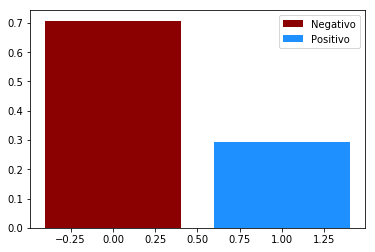

In [0]:
pred = predict_sentiment(net, "Rocks are NOT stones!")


plt.bar(0, 1-pred, color='darkred', label='Negativo')
plt.bar(1, pred, color='dodgerblue', label='Positivo')
plt.legend()
plt.show()